# Text translation using seq2seq architectures
 
Based on Tensorflow tutorial [Neural machine translation with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

Training a sequence-to-sequence (seq2seq) model similar to from [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5)

- not the most current architecture, but a good learning step for seq2seq models and attention before moving to Transformers
- will allow direct Spanish-English translation
- exports model as a tf.saved_model for use in other environments
- attention plot is more interesting than the resulting output - shows what parts of the input sentence "has the model's attention" while translating

With modifications described along the way...this does not currently leverage any available GPU, but will by the time we're done...

## Step 0 - Environment Setup 

assumes tensorflow-text >= 2.10, matplotlib and einops are installed in the environment

In [4]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [5]:
local_data_path_root = "C:/LocalResearch/JPD-Research/translationWork"

include helper class to check shapes correctly:

In [6]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Step 1 - Getting the data

Uses [Anki](http://www.manythings.org/anki/) dataset with translation pairs such as english-spanish text - more languages are available

1. Download the dataset
2. Add a start and end token to each sentence.
1. Clean the sentences by removing special characters.
1. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
1. Pad each sentence to a maximum length

### Download the dataset

In [7]:
# Download the file
import pathlib
local_data_path = local_data_path_root+ "/data"

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    cache_subdir=local_data_path,
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [8]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [9]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])
print()
print(target_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Prepare the dataset

start with a tf.dataset

In [10]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Boston es mi casa.' b'Estoy ocupado ahora y no puedo jugar con vos.'
 b'Tom le dese\xc3\xb3 buena suerte a Mary.'
 b'\xc2\xbfQu\xc3\xa9 estamos haciendo?'
 b'Tom quer\xc3\xada despedir a Mary, pero John se lo impidi\xc3\xb3.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Boston is my home.' b"I am busy now and can't play with you."
 b'Tom wished Mary good luck.' b'What are we doing?'
 b'Tom wanted to fire Mary, but John stopped him.'], shape=(5,), dtype=string)


### Preprocess the text

- standardization
  - unicode normalization - split accented characters and replace compat chars with ascii equivalents  
- vectorization
  - handles vocabulary extraction and conversion of input text into token sequences   

In [12]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [13]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [15]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [16]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [17]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [18]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 137, 15, 24, 53, 4, 3],
 [2, 41, 340, 92, 33, 9, 55, 325, 27, 469, 4, 3],
 [2, 10, 28, 1073, 210, 533, 8, 32, 4, 3]]>

In [19]:
print(example_tokens[0].numpy())
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)
print(example_tokens.to_tensor()[0])
print(tokens)

[  2 137  15  24  53   4   3]
tf.Tensor([  2 137  15  24  53   4   3   0   0   0   0   0   0   0   0   0], shape=(16,), dtype=int64)
['[START]' 'boston' 'es' 'mi' 'casa' '.' '[END]']


you can see from the above that the returned tensors are zero padded - these can be used to form a mask

Text(0.5, 1.0, 'Mask')

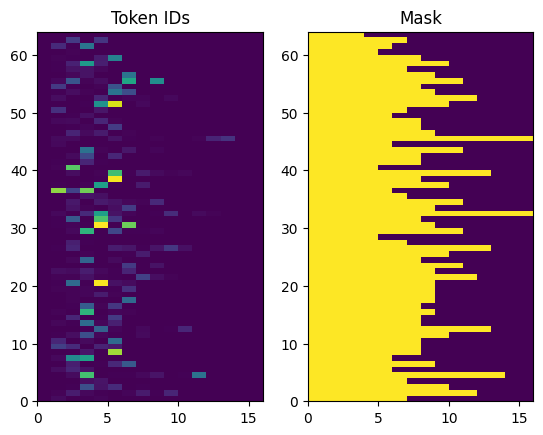

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### process the dataset

in the following function, (context, target) becomes ((context,target_in), target_out) for training
keras expects (inputs, label) where here, (context, target_in) is the input, and target_out is the label
the difference between _in and _out is that _out is shifted one character right, so at each location, the label is the next token (expected value)

In [21]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   10   17 3177   31  323    4    3    0    0]

[   2    9 3377    7   93    4    0    0    0    0]
[   9 3377    7   93    4    3    0    0    0    0]


## Step 2 - The encoder / decoder architecture and model

two simplifications from the original attention-based translation model - typically unnecessary:
- feeding state from encoder's RNN to the decoder's RNN
- Feeding attention output back to the RNN input 


In [23]:
UNITS = 256

### The encoder design

since context sequence is constant, information can flow between any units in the encoder, so use a bidirectional RNN

1. gets a list of token IDs
2. looks up an embedding vector for each token
3. processes the embeddings into a new sequence (using a bidirectional RNN
4. returns the processed sequence -> attention head

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [25]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 21)
Encoder output, shape (batch, s, units): (64, 21, 256)
